# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups
Sample_111  Q8WZA1           17.844
Sample_074  O75368           14.992
Sample_188  P06702           12.874
Sample_095  P09104           16.041
Sample_195  O15335           15.591
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups      
Sample_158  F5H423;P61204;P84077   13.239
Sample_050  O75781;O75781-2        15.784
Sample_173  Q16799                 13.382
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 14.266
            A0A075B6Q5                 12.810
            A0A075B6R2                 13.362
            A0A075B6S5                 13.043
            A0A087WSY4                 12.349
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.118
            Q9UI40;Q9UI40-2            12.699
            Q9UIW2                     12.601
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.190
            Q9UP79                     12.132
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.180,15.050,16.842,19.863,15.647,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.841,19.067,...,15.528,15.576,14.078,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.550,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,16.009,17.705,17.039,16.404,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.291,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.307,15.345,17.084,18.708,14.249,19.433,12.184,11.169
Sample_207,15.739,16.877,15.469,16.898,15.010,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,14.266,...,16.012,15.178,12.779,15.050,16.842,19.863,12.554,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.005,19.067,16.188,...,15.528,15.576,12.765,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.805,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,13.176,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.272,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.896,15.345,17.084,18.708,14.249,19.433,12.238,12.597
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 338.63it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.79it/s]

100%|██████████| 2/2 [00:00<00:00,  4.77it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.49it/s]

100%|██████████| 3/3 [00:00<00:00,  3.60it/s]

100%|██████████| 3/3 [00:00<00:00,  3.73it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.20it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.36it/s]

100%|██████████| 4/4 [00:00<00:00,  3.85it/s]

100%|██████████| 4/4 [00:00<00:00,  4.17it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.23it/s]

 60%|██████    | 3/5 [00:00<00:00,  2.99it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.05it/s]

100%|██████████| 5/5 [00:01<00:00,  3.18it/s]

100%|██████████| 5/5 [00:01<00:00,  3.22it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.38it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.69it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.37it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.01it/s]

100%|██████████| 6/6 [00:01<00:00,  2.70it/s]

100%|██████████| 6/6 [00:01<00:00,  3.08it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.11it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.31it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.87it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.59it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.35it/s]

100%|██████████| 7/7 [00:02<00:00,  2.51it/s]

100%|██████████| 7/7 [00:02<00:00,  2.71it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.94it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.36it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.38it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.15it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.18it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.36it/s]

100%|██████████| 8/8 [00:03<00:00,  2.48it/s]

100%|██████████| 8/8 [00:03<00:00,  2.54it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.41it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.58it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.06it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.04it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.02it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.95it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.73it/s]

100%|██████████| 9/9 [00:02<00:00,  3.04it/s]

100%|██████████| 9/9 [00:02<00:00,  3.09it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.75it/s]

 30%|███       | 3/10 [00:00<00:01,  4.60it/s]

 40%|████      | 4/10 [00:01<00:01,  3.54it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.45it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.58it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.48it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.31it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.22it/s]

100%|██████████| 10/10 [00:02<00:00,  3.17it/s]

100%|██████████| 10/10 [00:02<00:00,  3.49it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.92it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.73it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.31it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.87it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.92it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.86it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.59it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.68it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.48it/s]

100%|██████████| 11/11 [00:02<00:00,  3.32it/s]

100%|██████████| 11/11 [00:02<00:00,  3.77it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.52it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.48it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.93it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.52it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.47it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.02it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.66it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.46it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.21it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  1.97it/s]

100%|██████████| 12/12 [00:04<00:00,  2.04it/s]

100%|██████████| 12/12 [00:04<00:00,  2.62it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.75it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.18it/s]

 31%|███       | 4/13 [00:00<00:02,  3.89it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.53it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.44it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.40it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.36it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.88it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.50it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.49it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.42it/s]

100%|██████████| 13/13 [00:04<00:00,  2.46it/s]

100%|██████████| 13/13 [00:04<00:00,  2.94it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.77it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.22it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.74it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.89it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.45it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.38it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.25it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.11it/s]

 71%|███████▏  | 10/14 [00:04<00:02,  1.94it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  1.91it/s]

 86%|████████▌ | 12/14 [00:05<00:01,  1.96it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.15it/s]

100%|██████████| 14/14 [00:05<00:00,  2.26it/s]

100%|██████████| 14/14 [00:05<00:00,  2.38it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.46it/s]

 20%|██        | 3/15 [00:00<00:03,  3.81it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.59it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.01it/s]

 40%|████      | 6/15 [00:01<00:03,  2.57it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.30it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.21it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.33it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.41it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.61it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.60it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.62it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.72it/s]

100%|██████████| 15/15 [00:05<00:00,  2.41it/s]

100%|██████████| 15/15 [00:05<00:00,  2.63it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.053 0.015          0.694 0.405       0.103   
2             0.004 0.002      0.048 0.010          0.707 0.085       0.599   
3             0.004 0.001      0.049 0.009          0.689 0.101       0.597   
4             0.005 0.003      0.058 0.022          0.764 0.106       0.610   
5             0.004 0.000      0.062 0.035          0.706 0.084       0.660   
6             0.007 0.007      0.097 0.035          0.770 0.084       0.810   
7             0.007 0.005      0.093 0.037          0.776 0.080       0.810   
8             0.003 0.001      0.042 0.014          0.770 0.084       0.798   
9             0.004 0.003      0.047 0.021          0.777 0.078       0.810   
10            0.005 0.003      0.060 0.024          0.781 0.079       0.814   
11            0.009 0.007      0.094 0.029          0.787 0.082       0.796   
12            0.005 0.005      0.060 0.020          0.812 0.077       0.803   
13            0.007 0.007      0.067 0.026          0.833 0.079       0.812   
14            0.005 0.003      0.067 0.027          0.834 0.078       0.816   
15            0.008 0.007      0.069 0.029          0.814 0.078       0.807   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.087   0.172 0.134                  0.544 0.042        0.844   
2          0.102   0.643 0.078                  0.707 0.057        0.776   
3          0.111   0.633 0.085                  0.697 0.063        0.764   
4          0.119   0.671 0.094                  0.733 0.067        0.787   
5          0.110   0.677 0.077                  0.728 0.060        0.792   
6          0.118   0.784 0.079                  0.815 0.068        0.884   
7          0.108   0.788 0.074                  0.819 0.064        0.884   
8          0.112   0.779 0.076                  0.811 0.064        0.885   
9          0.108   0.790 0.075                  0.820 0.065        0.893   
10         0.103   0.793 0.071                  0.823 0.061        0.893   
11         0.102   0.788 0.074                  0.819 0.064        0.893   
12         0.102   0.803 0.072                  0.833 0.060        0.903   
13         0.100   0.818 0.069                  0.845 0.057        0.909   
14         0.097   0.821 0.066                  0.847 0.055        0.908   
15         0.090   0.807 0.066                  0.835 0.056        0.908   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.813 0.084        210.000 0.000  
2          0.067                  0.752 0.083        210.000 0.000  
3          0.071                  0.738 0.088        210.000 0.000  
4          0.067                  0.750 0.082        210.000 0.000  
5          0.064                  0.756 0.079        210.000 0.000  
6          0.049                  0.853 0.061        210.000 0.000  
7          0.050                  0.851 0.061        210.000 0.000  
8          0.050                  0.856 0.059        210.000 0.000  
9          0.050                  0.876 0.052        210.000 0.000  
10         0.050                  0.877 0.051        210.000 0.000  
11         0.050                  0.875 0.053        210.000 0.000  
12         0.048                  0.891 0.046        210.000 0.000  
13         0.050                  0.896 0.049        210.000 0.000  
14         0.050                  0.895 0.047        210.000 0.000  
15         0.047                  0.895 0.045 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 149.60it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.35it/s]

100%|██████████| 2/2 [00:00<00:00,  4.33it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.06it/s]

100%|██████████| 3/3 [00:01<00:00,  2.75it/s]

100%|██████████| 3/3 [00:01<00:00,  2.93it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.81it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.36it/s]

100%|██████████| 4/4 [00:01<00:00,  2.93it/s]

100%|██████████| 4/4 [00:01<00:00,  3.15it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.30it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.44it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.20it/s]

100%|██████████| 5/5 [00:02<00:00,  2.26it/s]

100%|██████████| 5/5 [00:02<00:00,  2.36it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.51it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.34it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.06it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  2.09it/s]

100%|██████████| 6/6 [00:02<00:00,  2.00it/s]

100%|██████████| 6/6 [00:02<00:00,  2.15it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.44it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.28it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.25it/s]

 71%|███████▏  | 5/7 [00:02<00:00,  2.43it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.45it/s]

100%|██████████| 7/7 [00:02<00:00,  2.41it/s]

100%|██████████| 7/7 [00:02<00:00,  2.44it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.79it/s]

 38%|███▊      | 3/8 [00:00<00:01,  2.89it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.53it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.36it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.51it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.71it/s]

100%|██████████| 8/8 [00:02<00:00,  2.76it/s]

100%|██████████| 8/8 [00:02<00:00,  2.71it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  3.97it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.75it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.58it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.54it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.47it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.54it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.59it/s]

100%|██████████| 9/9 [00:03<00:00,  2.67it/s]

100%|██████████| 9/9 [00:03<00:00,  2.67it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.95it/s]

 30%|███       | 3/10 [00:00<00:02,  3.43it/s]

 40%|████      | 4/10 [00:01<00:02,  2.92it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.50it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.44it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.38it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.37it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.07it/s]

100%|██████████| 10/10 [00:04<00:00,  1.86it/s]

100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  3.88it/s]

 27%|██▋       | 3/11 [00:01<00:02,  2.83it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.65it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.68it/s]

 55%|█████▍    | 6/11 [00:02<00:01,  2.76it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.82it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.84it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.33it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.24it/s]

100%|██████████| 11/11 [00:04<00:00,  2.10it/s]

100%|██████████| 11/11 [00:04<00:00,  2.47it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.88it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.04it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.49it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.25it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.52it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.19it/s]

 67%|██████▋   | 8/12 [00:03<00:02,  1.87it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  1.72it/s]

 83%|████████▎ | 10/12 [00:04<00:01,  1.74it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  1.72it/s]

100%|██████████| 12/12 [00:05<00:00,  1.90it/s]

100%|██████████| 12/12 [00:05<00:00,  2.18it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.85it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.58it/s]

 31%|███       | 4/13 [00:01<00:02,  3.11it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.01it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.89it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.34it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.10it/s]

 69%|██████▉   | 9/13 [00:03<00:02,  1.95it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  1.96it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.08it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.09it/s]

100%|██████████| 13/13 [00:05<00:00,  1.93it/s]

100%|██████████| 13/13 [00:05<00:00,  2.29it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.62it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.57it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.24it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.45it/s]

 43%|████▎     | 6/14 [00:02<00:04,  1.90it/s]

 50%|█████     | 7/14 [00:03<00:04,  1.73it/s]

 57%|█████▋    | 8/14 [00:03<00:03,  1.66it/s]

 64%|██████▍   | 9/14 [00:04<00:03,  1.64it/s]

 71%|███████▏  | 10/14 [00:04<00:02,  1.67it/s]

 79%|███████▊  | 11/14 [00:05<00:01,  1.76it/s]

 86%|████████▌ | 12/14 [00:05<00:01,  1.86it/s]

 93%|█████████▎| 13/14 [00:06<00:00,  1.99it/s]

100%|██████████| 14/14 [00:06<00:00,  2.03it/s]

100%|██████████| 14/14 [00:06<00:00,  2.05it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.85it/s]

 20%|██        | 3/15 [00:01<00:05,  2.38it/s]

 27%|██▋       | 4/15 [00:01<00:05,  1.93it/s]

 33%|███▎      | 5/15 [00:02<00:05,  1.73it/s]

 40%|████      | 6/15 [00:03<00:05,  1.66it/s]

 47%|████▋     | 7/15 [00:03<00:04,  1.75it/s]

 53%|█████▎    | 8/15 [00:04<00:03,  1.89it/s]

 60%|██████    | 9/15 [00:04<00:02,  2.05it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.17it/s]

 73%|███████▎  | 11/15 [00:05<00:01,  2.25it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.32it/s]

 87%|████████▋ | 13/15 [00:06<00:00,  2.30it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.24it/s]

100%|██████████| 15/15 [00:07<00:00,  2.36it/s]

100%|██████████| 15/15 [00:07<00:00,  2.13it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.007 0.006      0.082 0.033          0.000 0.000       0.000   
2             0.005 0.004      0.060 0.023          0.695 0.113       0.585   
3             0.004 0.003      0.053 0.018          0.798 0.105       0.706   
4             0.005 0.005      0.065 0.023          0.779 0.104       0.690   
5             0.006 0.004      0.069 0.028          0.827 0.089       0.756   
6             0.005 0.003      0.061 0.022          0.815 0.098       0.765   
7             0.004 0.002      0.058 0.021          0.815 0.100       0.770   
8             0.005 0.004      0.069 0.040          0.811 0.100       0.765   
9             0.007 0.005      0.070 0.027          0.812 0.111       0.760   
10            0.005 0.003      0.062 0.022          0.834 0.092       0.774   
11            0.007 0.006      0.074 0.036          0.827 0.092       0.783   
12            0.005 0.002      0.059 0.020          0.824 0.090       0.782   
13            0.007 0.008      0.070 0.030          0.824 0.085       0.813   
14            0.004 0.001      0.049 0.010          0.844 0.076       0.811   
15            0.006 0.005      0.064 0.028          0.845 0.075       0.812   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.497 0.008        0.847   
2          0.103   0.630 0.089                  0.696 0.067        0.780   
3          0.119   0.741 0.085                  0.784 0.067        0.866   
4          0.120   0.724 0.087                  0.770 0.069        0.871   
5          0.099   0.785 0.070                  0.819 0.056        0.901   
6          0.097   0.784 0.071                  0.817 0.059        0.901   
7          0.101   0.786 0.072                  0.818 0.060        0.902   
8          0.101   0.781 0.072                  0.814 0.061        0.900   
9          0.107   0.779 0.086                  0.812 0.072        0.898   
10         0.098   0.798 0.071                  0.828 0.059        0.921   
11         0.099   0.799 0.071                  0.829 0.059        0.922   
12         0.096   0.797 0.069                  0.828 0.057        0.921   
13         0.091   0.814 0.066                  0.841 0.056        0.926   
14         0.086   0.823 0.058                  0.849 0.049        0.929   
15         0.092   0.824 0.060                  0.850 0.051        0.931   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.819 0.090        210.000 0.000  
2          0.067                  0.730 0.098        210.000 0.000  
3          0.054                  0.844 0.069        210.000 0.000  
4          0.052                  0.849 0.061        210.000 0.000  
5          0.049                  0.884 0.058        210.000 0.000  
6          0.048                  0.884 0.059        210.000 0.000  
7          0.048                  0.884 0.058        210.000 0.000  
8          0.049                  0.882 0.059        210.000 0.000  
9          0.051                  0.879 0.062        210.000 0.000  
10         0.044                  0.898 0.059        210.000 0.000  
11         0.044                  0.902 0.056        210.000 0.000  
12         0.045                  0.901 0.056        210.000 0.000  
13         0.043                  0.905 0.050        210.000 0.000  
14         0.041                  0.908 0.049        210.000 0.000  
15         0.041                  0.911 0.048 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1034.86it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 26.47it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 14.96it/s]

100%|██████████| 3/3 [00:00<00:00, 14.40it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 16.29it/s]

100%|██████████| 4/4 [00:00<00:00, 12.03it/s]

100%|██████████| 4/4 [00:00<00:00, 12.47it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 15.25it/s]

100%|██████████| 5/5 [00:00<00:00, 11.49it/s]

100%|██████████| 5/5 [00:00<00:00, 11.94it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 22.24it/s]

100%|██████████| 6/6 [00:00<00:00, 16.97it/s]

100%|██████████| 6/6 [00:00<00:00, 17.55it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 16.00it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 11.03it/s]

100%|██████████| 7/7 [00:00<00:00, 10.48it/s]

100%|██████████| 7/7 [00:00<00:00, 10.98it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 14.01it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 11.23it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 11.28it/s]

100%|██████████| 8/8 [00:00<00:00, 11.85it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 18.63it/s]

 44%|████▍     | 4/9 [00:00<00:00, 14.99it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 11.57it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 11.02it/s]

100%|██████████| 9/9 [00:00<00:00, 11.89it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 17.16it/s]

 40%|████      | 4/10 [00:00<00:00, 11.75it/s]

 60%|██████    | 6/10 [00:00<00:00, 11.02it/s]

 80%|████████  | 8/10 [00:00<00:00, 10.61it/s]

100%|██████████| 10/10 [00:00<00:00, 10.56it/s]

100%|██████████| 10/10 [00:00<00:00, 10.96it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 15.90it/s]

 45%|████▌     | 5/11 [00:00<00:00, 12.31it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 11.46it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 11.27it/s]

100%|██████████| 11/11 [00:00<00:00, 10.38it/s]

100%|██████████| 11/11 [00:01<00:00, 10.97it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 16.30it/s]

 42%|████▏     | 5/12 [00:00<00:00, 14.42it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 12.73it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 12.58it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 12.24it/s]

100%|██████████| 12/12 [00:00<00:00, 12.77it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 17.08it/s]

 31%|███       | 4/13 [00:00<00:00, 11.28it/s]

 46%|████▌     | 6/13 [00:00<00:00, 10.23it/s]

 62%|██████▏   | 8/13 [00:00<00:00,  9.25it/s]

 69%|██████▉   | 9/13 [00:00<00:00,  9.25it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  9.78it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  9.63it/s]

100%|██████████| 13/13 [00:01<00:00, 10.14it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 11.10it/s]

 36%|███▌      | 5/14 [00:00<00:00, 10.04it/s]

 43%|████▎     | 6/14 [00:00<00:00,  9.91it/s]

 50%|█████     | 7/14 [00:00<00:00,  9.18it/s]

 64%|██████▍   | 9/14 [00:00<00:00,  9.88it/s]

 79%|███████▊  | 11/14 [00:01<00:00, 10.72it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 12.02it/s]

100%|██████████| 14/14 [00:01<00:00, 11.10it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01, 12.32it/s]

 27%|██▋       | 4/15 [00:00<00:01,  9.74it/s]

 40%|████      | 6/15 [00:00<00:00,  9.14it/s]

 47%|████▋     | 7/15 [00:00<00:01,  7.97it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  8.10it/s]

 60%|██████    | 9/15 [00:01<00:00,  7.60it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  7.47it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  6.74it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  7.90it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  8.11it/s]

100%|██████████| 15/15 [00:01<00:00,  8.28it/s]

100%|██████████| 15/15 [00:01<00:00,  8.16it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.072 0.028          0.000 0.000       0.000   
2             0.007 0.007      0.076 0.034          0.641 0.148       0.424   
3             0.004 0.003      0.057 0.019          0.673 0.128       0.502   
4             0.007 0.006      0.078 0.033          0.675 0.120       0.486   
5             0.004 0.002      0.051 0.022          0.660 0.136       0.487   
6             0.006 0.005      0.061 0.019          0.649 0.124       0.506   
7             0.004 0.003      0.051 0.016          0.639 0.115       0.487   
8             0.005 0.004      0.058 0.021          0.636 0.116       0.487   
9             0.005 0.004      0.066 0.027          0.668 0.101       0.572   
10            0.007 0.006      0.080 0.024          0.672 0.104       0.570   
11            0.006 0.006      0.075 0.040          0.712 0.108       0.622   
12            0.006 0.004      0.078 0.024          0.696 0.111       0.609   
13            0.007 0.006      0.072 0.025          0.690 0.078       0.607   
14            0.004 0.002      0.056 0.019          0.705 0.101       0.638   
15            0.005 0.003      0.060 0.027          0.708 0.099       0.632   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.736   
2          0.118   0.504 0.115                  0.624 0.074        0.707   
3          0.084   0.570 0.085                  0.658 0.064        0.730   
4          0.097   0.558 0.085                  0.654 0.059        0.726   
5          0.092   0.554 0.090                  0.647 0.067        0.722   
6          0.096   0.562 0.085                  0.649 0.065        0.734   
7          0.089   0.548 0.082                  0.640 0.060        0.735   
8          0.085   0.547 0.081                  0.639 0.060        0.729   
9          0.108   0.611 0.089                  0.681 0.068        0.750   
10         0.108   0.611 0.090                  0.682 0.067        0.747   
11         0.123   0.657 0.093                  0.717 0.070        0.790   
12         0.130   0.643 0.102                  0.706 0.076        0.782   
13         0.103   0.641 0.075                  0.703 0.057        0.801   
14         0.117   0.664 0.090                  0.720 0.070        0.813   
15         0.115   0.662 0.089                  0.720 0.068        0.810   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.068                  0.686 0.087        210.000 0.000  
2          0.069                  0.668 0.087        210.000 0.000  
3          0.068                  0.690 0.091        210.000 0.000  
4          0.068                  0.689 0.089        210.000 0.000  
5          0.069                  0.687 0.086        210.000 0.000  
6          0.066                  0.696 0.087        210.000 0.000  
7          0.067                  0.701 0.087        210.000 0.000  
8          0.068                  0.695 0.089        210.000 0.000  
9          0.065                  0.709 0.088        210.000 0.000  
10         0.064                  0.705 0.088        210.000 0.000  
11         0.075                  0.740 0.088        210.000 0.000  
12         0.075                  0.733 0.089        210.000 0.000  
13         0.063                  0.753 0.080        210.000 0.000  
14         0.060                  0.769 0.073        210.000 0.000  
15         0.062                  0.766 0.074 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,11,9,2
score_time,6,1,10
test_precision,14,15,11
test_recall,14,13,14
test_f1,14,15,14
test_balanced_accuracy,14,15,14
test_roc_auc,13,15,14
test_average_precision,13,15,14
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.48it/s]

 20%|██        | 3/15 [00:00<00:03,  3.36it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.13it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.01it/s]

 40%|████      | 6/15 [00:01<00:03,  2.83it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.59it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.54it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.64it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.57it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.41it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.48it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.18it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.04it/s]

100%|██████████| 15/15 [00:06<00:00,  2.09it/s]

100%|██████████| 15/15 [00:06<00:00,  2.48it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 16.23it/s]

 36%|███▌      | 5/14 [00:00<00:00, 13.50it/s]

 50%|█████     | 7/14 [00:00<00:00, 12.24it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 11.16it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 11.24it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 11.56it/s]

100%|██████████| 14/14 [00:01<00:00, 11.88it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.82it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.43it/s]

 31%|███       | 4/13 [00:00<00:02,  3.95it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.62it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.53it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.38it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.29it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.33it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.64it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.20it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.07it/s]

100%|██████████| 13/13 [00:04<00:00,  1.95it/s]

100%|██████████| 13/13 [00:04<00:00,  2.71it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


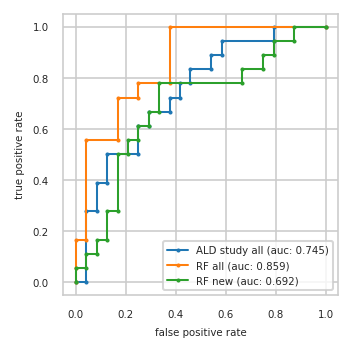

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.042 0.000  0.000 0.056  0.000 0.056
2          0.042 0.278  0.000 0.167  0.042 0.056
3          0.083 0.278  0.042 0.167  0.042 0.111
4          0.083 0.389  0.042 0.556  0.083 0.111
5          0.125 0.389  0.167 0.556  0.083 0.167
6          0.125 0.500  0.167 0.722  0.125 0.167
7          0.250 0.500  0.250 0.722  0.125 0.278
8          0.250 0.611  0.250 0.778  0.167 0.278
9          0.292 0.611  0.375 0.778  0.167 0.500
10         0.292 0.667  0.375 1.000  0.208 0.500
11         0.375 0.667  1.000 1.000  0.208 0.556
12         0.375 0.722    NaN   NaN  0.250 0.556
13         0.417 0.722    NaN   NaN  0.250 0.611
14         0.417 0.778    NaN   NaN  0.292 0.611
15         0.458 0.778    NaN   NaN  0.292 0.667
16         0.458 0.833    NaN   NaN  0.333 0.667
17         0.542 0.833    NaN   NaN  0.333 0.778
18         0.542 0.889    NaN   NaN  0.667 0.778
19         0.583 0.889    NaN   NaN  0.667 0.833
20         0.583 0.944    NaN   NaN  0.750 0.833
21         0.792 0.944    NaN   NaN  0.750 0.889
22         0.792 1.000    NaN   NaN  0.792 0.889
23         1.000 1.000    NaN   NaN  0.792 0.944
24           NaN   NaN    NaN   NaN  0.875 0.944
25           NaN   NaN    NaN   NaN  0.875 1.000
26           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P04075,Q9Y2T3;Q9Y2T3-3,Q14894
1,Q07507,P60709;P63261,E5RK69;E7EMC6;P08133;P08133-2
2,Q9NRN5,P15151-2,J3KSJ8;Q9UD71;Q9UD71-2
3,P61981,P10636-2;P10636-6,P31321
4,Q9Y2T3;Q9Y2T3-3,P04075,Q96GD0
5,Q99983,P14174,Q9NUQ9
6,P10636-2;P10636-6,P61981,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
7,P14174,P25189;P25189-2,A0A0J9YW36;Q9NZ72;Q9NZ72-2
8,P00338;P00338-3,A0A0B4J1Z1;C9JAB2;Q16629;Q16629-2;Q16629-3;Q16...,P31150


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


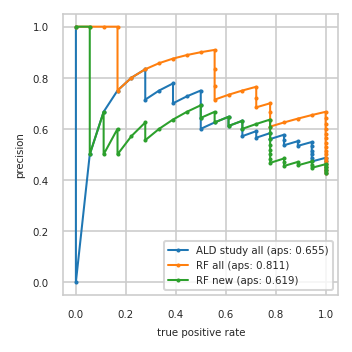

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.472 0.944     0.500 1.000     0.472 0.944
7          0.486 0.944     0.514 1.000     0.457 0.889
8          0.500 0.944     0.529 1.000     0.471 0.889
9          0.515 0.944     0.545 1.000     0.455 0.833
10         0.531 0.944     0.562 1.000     0.469 0.833
11         0.548 0.944     0.581 1.000     0.484 0.833
12         0.533 0.889     0.600 1.000     0.467 0.778
13         0.552 0.889     0.621 1.000     0.483 0.778
14         0.536 0.833     0.643 1.000     0.500 0.778
15         0.556 0.833     0.667 1.000     0.519 0.778
16         0.577 0.833     0.654 0.944     0.538 0.778
17         0.560 0.778     0.640 0.889     0.560 0.778
18         0.583 0.778     0.625 0.833     0.583 0.778
19         0.565 0.722     0.609 0.778     0.609 0.778
20         0.591 0.722     0.636 0.778     0.636 0.778
21         0.571 0.667     0.667 0.778     0.619 0.722
22         0.600 0.667     0.700 0.778     0.600 0.667
23         0.632 0.667     0.684 0.722     0.632 0.667
24         0.611 0.611     0.722 0.722     0.611 0.611
25         0.647 0.611     0.765 0.722     0.647 0.611
26         0.625 0.556     0.750 0.667     0.625 0.556
27         0.600 0.500     0.733 0.611     0.667 0.556
28         0.643 0.500     0.714 0.556     0.643 0.500
29         0.692 0.500     0.769 0.556     0.692 0.500
30         0.750 0.500     0.833 0.556     0.667 0.444
31         0.727 0.444     0.909 0.556     0.636 0.389
32         0.700 0.389     0.900 0.500     0.600 0.333
33         0.778 0.389     0.889 0.444     0.556 0.278
34         0.750 0.333     0.875 0.389     0.625 0.278
35         0.714 0.278     0.857 0.333     0.571 0.222
36         0.833 0.278     0.833 0.278     0.500 0.167
37         0.800 0.222     0.800 0.222     0.600 0.167
38         0.750 0.167     0.750 0.167     0.500 0.111
39         0.667 0.111     1.000 0.167     0.667 0.111
40         0.500 0.056     1.000 0.111     0.500 0.056
41         0.000 0.000     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


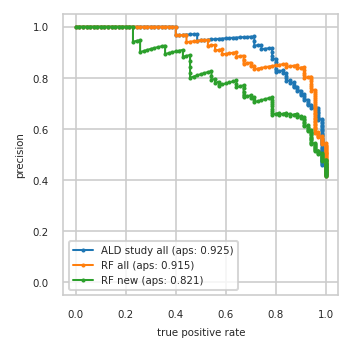

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


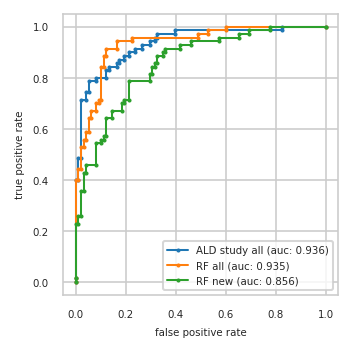

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}